In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
model_error_args = {
    "nx": 700,
    "ny": 500,
    "dx": 300.0,
    "dy": 300.0,
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

model_error_args_coarse = {
    "nx": 70,
    "ny": 50,
    "dx": 3000.0,
    "dy": 3000.0,
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

model_error_args_5 = {
    "nx": 140,
    "ny": 100,
    "dx": 1500.0,
    "dy": 1500.0,
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

def make_init_fields(args):
    dataShape = (args["ny"] + 4, args["nx"] + 4)
    dataShapeH = (args["ny"] + 5, args["nx"] + 5)

    eta = np.zeros(dataShape, dtype=np.float32)
    hu  = np.zeros(dataShape, dtype=np.float32)
    hv  = np.zeros(dataShape, dtype=np.float32)
    Hi = np.ones(dataShapeH, dtype=np.float32)*60

    return {"eta": eta, "hu": hu, "hv": hv, "Hi": Hi}

def imshow(data):
    fig = plt.figure()
    plt.imshow(data, origin="lower")
    plt.colorbar()

def imshowDataArgs(data_args):
    imshow3(data_args["eta"], data_args["hu"], data_args["hv"])

def imshowSim(sim):
    eta, hu, hv = sim.download(interior_domain_only=False)
    imshow3(eta, hu, hv)

def imshow3(eta, hu, hv):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    eta_im = axs[0].imshow(eta[2:-2, 2:-2], origin="lower")
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])

    hu_im = axs[1].imshow(hu[2:-2, 2:-2], origin="lower")
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    hv_im = axs[2].imshow(hv[2:-2, 2:-2], origin="lower")
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    


In [5]:
reload(ModelErrorKL)

mekl = ModelErrorKL.ModelErrorKL(**model_error_args, include_sin=True) #, basis_x_end=1, basis_y_end=1)

In [6]:
data_args = make_init_fields(model_error_args)
#mekl.perturbEtaCPU(data_args["eta"])


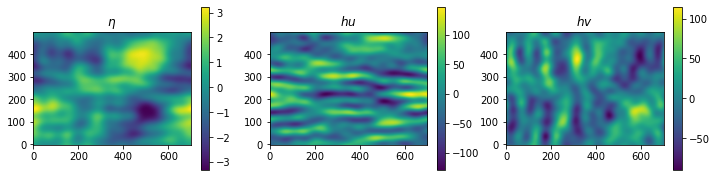

In [7]:
mekl.perturbOceanStateCPU(**data_args, **sample_args)
imshowDataArgs(data_args)

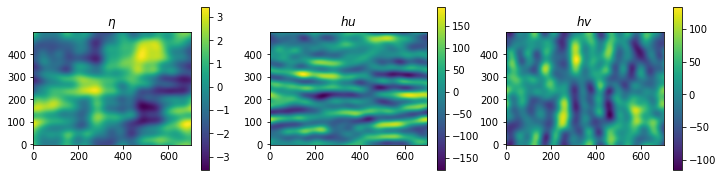

In [8]:
mekl.perturbOceanStateCPU(**data_args, **sample_args)
imshowDataArgs(data_args)

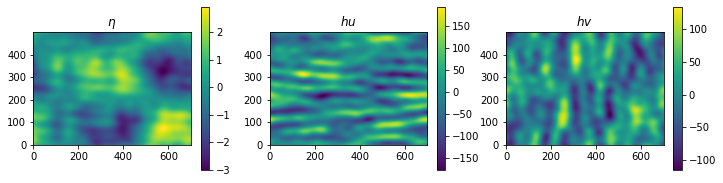

In [9]:
mekl.perturbEtaCPU(data_args["eta"])
imshowDataArgs(data_args)

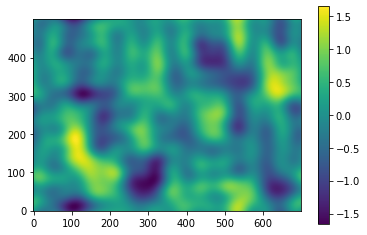

In [10]:
for i in range(10):
    mekl.perturbEtaCPU(data_args["eta"])

imshow(data_args["eta"][2:-2, 2:-2])

### Test perturbing two ocean states with different resolution 

In [13]:
reload(ModelErrorKL)
fine_data_args = make_init_fields(model_error_args)
fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args, include_sin=False) #, basis_x_end=1, basis_y_end=1)

coarse_data_args = make_init_fields(model_error_args_coarse)
coarse_mekl = ModelErrorKL.ModelErrorKL(**model_error_args_coarse, include_sin=False) #, basis_x_end=1, basis_y_end=1)

roll_fine = {
    "roll_x_sin": 0, #50,
    "roll_y_sin": 0, #340,
    "roll_x_cos": 0, #480,
    "roll_y_cos": 0, #160,
}
roll_coarse = {
    "roll_x_sin": 0, #5,
    "roll_y_sin": 0, #34,
    "roll_x_cos": 0, #40,
    "roll_y_cos": 0, #16,
}

In [14]:
fine_mekl.perturbOceanStateCPU(**fine_data_args, **sample_args, **roll_fine)


In [15]:
coarse_mekl.perturbOceanStateCPU(**coarse_data_args, **sample_args, **roll_coarse,
                                 random_numbers=fine_mekl.random_numbers_host)

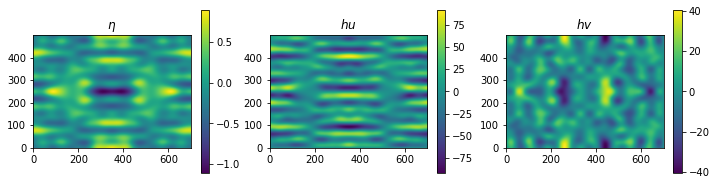

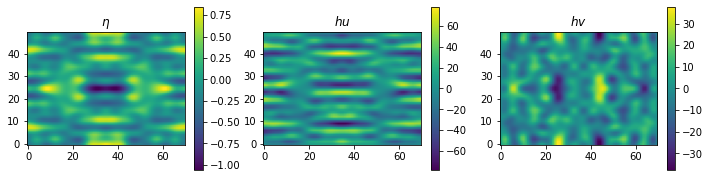

In [16]:
imshowDataArgs(fine_data_args)
imshowDataArgs(coarse_data_args)

In [17]:
fine_data_args["eta"].shape, coarse_data_args["eta"].shape

((504, 704), (54, 74))

# Start sim with one of these states 

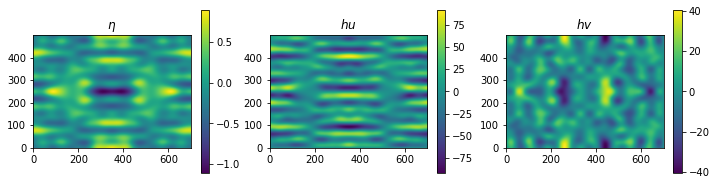

In [18]:
def make_sim(me_args, init_fields = None):
    if init_fields is None:
        init_fields = make_init_fields(me_args)

    sim_args = {
        "gpu_ctx" : gpu_ctx,
        "nx" : me_args["nx"],
        "ny" : me_args["ny"],
        "dx" : me_args["dx"],
        "dy" : me_args["dy"],
        "f"  : sample_args["f"],
        "g"  : sample_args["g"],
        "r"  : 0,
        "dt" : 0,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
        "eta0" : init_fields["eta"],
        "hu0"  : init_fields["hu"],
        "hv0"  : init_fields["hv"],
        "H"    : init_fields["Hi"],
    }

    return CDKLM16.CDKLM16(**sim_args)
sim = make_sim(model_error_args, fine_data_args)


imshowSim(sim)


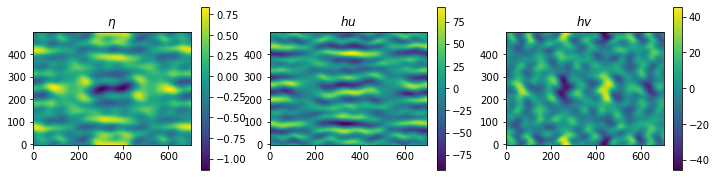

In [19]:
sim.step(10000)
imshowSim(sim)

# GPU 

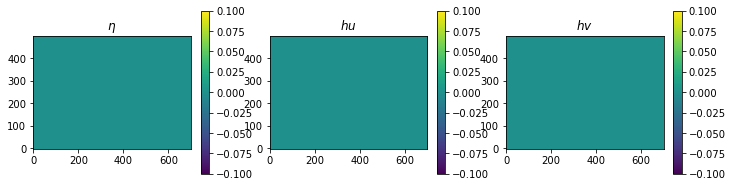

In [20]:
sim = make_sim(model_error_args)
imshowSim(sim)

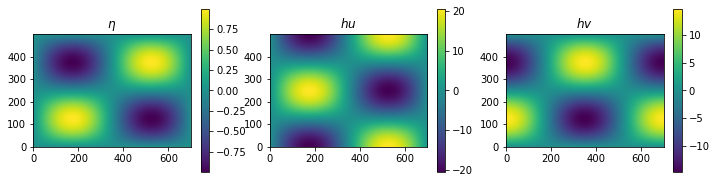

In [21]:
reload(ModelErrorKL)
fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args) # include_sin=False) #, basis_x_end=1, basis_y_end=1)
fine_mekl.random_numbers_host *= 0
fine_mekl.random_numbers_host[0,0] = 1
fine_mekl.perturbSim(sim, random_numbers=fine_mekl.random_numbers_host, roll_x_sin=0, roll_x_cos=0, roll_y_sin=0, roll_y_cos=0)
imshowSim(sim)

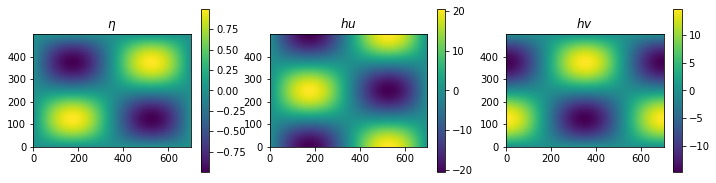

In [22]:
sim.step(10)
imshowSim(sim)

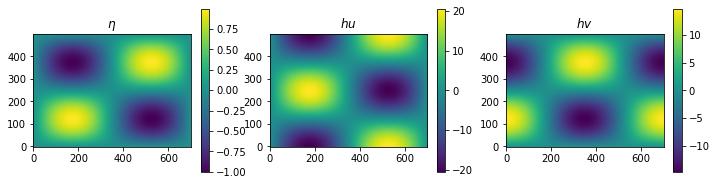

In [23]:
for i in range(1000):
    sim.step(10)
imshowSim(sim)

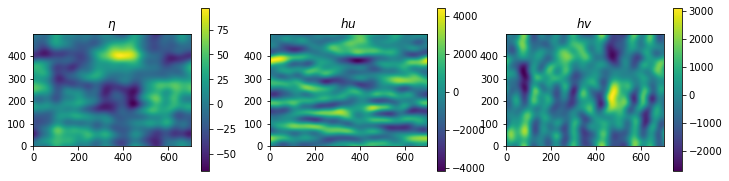

In [24]:
for i in range(1000):
    fine_mekl.perturbSim(sim)
imshowSim(sim)

### Check that eta is actually the same on different resolutions
We use a two grids with a factor 5 coarsening, meaning that there are cell-centers that match exactly and should have the exact same values for eta.

In [25]:
reload(ModelErrorKL)

sim = make_sim(model_error_args)
sim_5 = make_sim(model_error_args_5)

roll_x_sin=np.random.rand()
roll_x_cos=np.random.rand()
roll_y_sin=np.random.rand()
roll_y_cos=np.random.rand()


fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args) 
fine_mekl_5 = ModelErrorKL.ModelErrorKL(**model_error_args_5)

fine_mekl.perturbSim(sim, roll_x_sin=roll_x_sin, roll_x_cos=roll_x_cos, roll_y_sin=roll_y_sin, roll_y_cos=roll_y_cos)


In [26]:
fine_mekl_5.perturbSim(sim_5, random_numbers=fine_mekl.random_numbers, roll_x_sin=roll_x_sin, roll_x_cos=roll_x_cos, roll_y_sin=roll_y_sin, roll_y_cos=roll_y_cos, stream=fine_mekl_5.gpu_stream)

In [27]:
eta, hu, hv = sim.download(interior_domain_only=True)
eta_5, hu_5, hv_5 = sim_5.download(interior_domain_only=True)

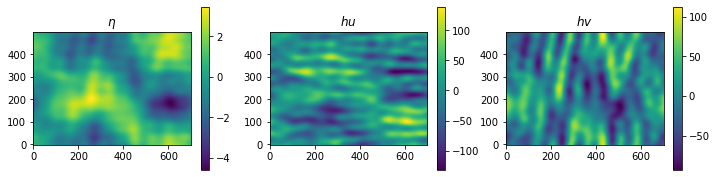

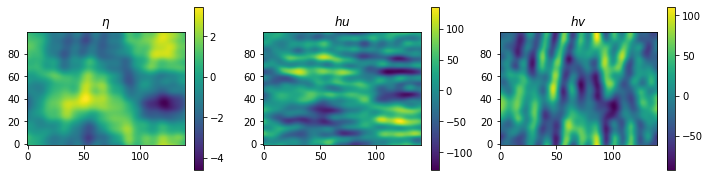

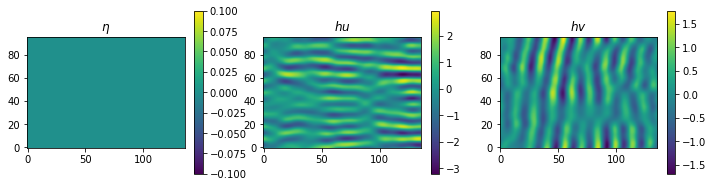

In [28]:
eta.shape, eta_5.shape, eta[2:-2:5, 2:-2:5].shape
imshowSim(sim)
imshowSim(sim_5)
imshow3(eta[2:-2:5, 2:-2:5] - eta_5, hu[2:-2:5, 2:-2:5] - hu_5, hv[2:-2:5, 2:-2:5] - hv_5)

In [29]:
# Compare with CPU version
host_eta = np.zeros_like(fine_data_args["eta"])

# Appearantly, we role the opposite way somehow on the CPU, and we need to roll with a full number of grid cells.
# The results are therefore not accurately the same, but sufficiently so to see that we do something right.
cpu_roll_x_sin=int(np.floor((1-roll_x_sin)*fine_mekl.nx))
cpu_roll_x_cos=int(np.floor((1-roll_x_cos)*fine_mekl.nx))
cpu_roll_y_sin=int(np.floor((1-roll_y_sin)*fine_mekl.ny))
cpu_roll_y_cos=int(np.floor((1-roll_y_cos)*fine_mekl.ny))

fine_mekl.perturbEtaCPU(host_eta, use_existing_GPU_random_numbers=True, roll_x_sin=cpu_roll_x_sin, roll_x_cos=cpu_roll_x_cos, roll_y_sin=cpu_roll_y_sin, roll_y_cos=cpu_roll_y_cos)

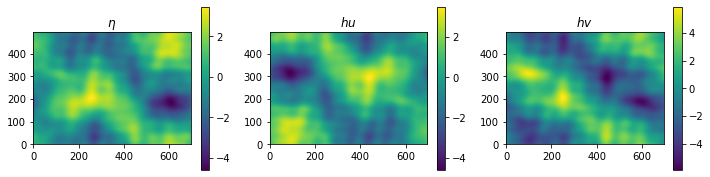

In [30]:
imshow3(eta, host_eta[2:-2, 2:-2], eta - host_eta[2:-2, 2:-2])

# Check that we can perturb the ocean state similarly to how we perturb eta

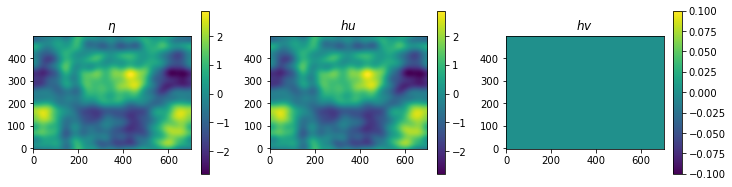

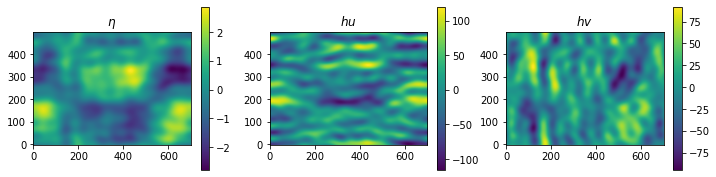

In [31]:
reload(ModelErrorKL)

sim1 = make_sim(model_error_args)
sim2 = make_sim(model_error_args)

roll_x_sin=np.random.rand()
roll_x_cos=np.random.rand()
roll_y_sin=np.random.rand()
roll_y_cos=np.random.rand()


fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args) 

fine_mekl.perturbEtaSim(sim1, roll_x_sin=roll_x_sin, roll_x_cos=roll_x_cos, roll_y_sin=roll_y_sin, roll_y_cos=roll_y_cos)
fine_mekl.perturbSim(sim2, update_random_field=False, roll_x_sin=roll_x_sin, roll_x_cos=roll_x_cos, roll_y_sin=roll_y_sin, roll_y_cos=roll_y_cos)

eta1, hu1, hv1 = sim1.download()
eta2, hu2, hv2 = sim2.download()

imshow3(eta1, eta2, eta1-eta2)
imshowSim(sim2)

# fig = plt.figure(figsize=(14,10))
# plt.imshow(hu2[200:-200,300:-300], origin='lower')
# plt.colorbar()


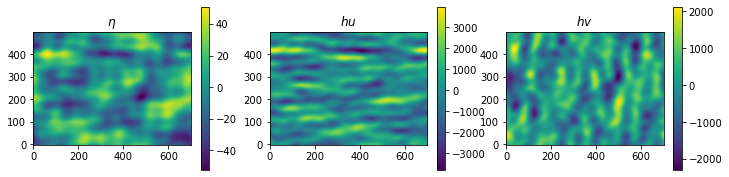

In [32]:
for i in range(1000):
    fine_mekl.perturbSim(sim2)
imshowSim(sim2)

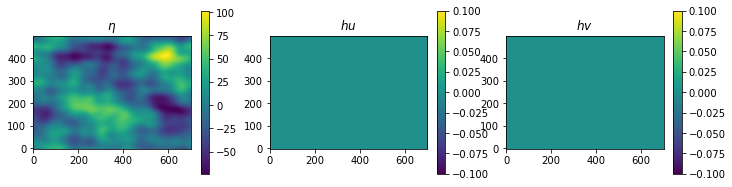

In [33]:
for i in range(1000):
    fine_mekl.perturbEtaSim(sim1)
imshowSim(sim1)



# Test running a perturbed state 
Is the perturbed state balanced?

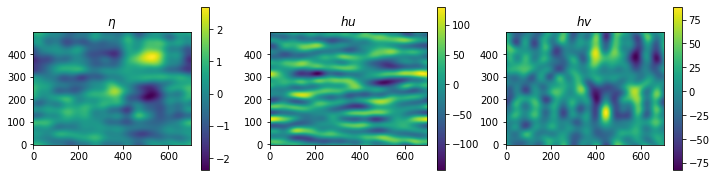

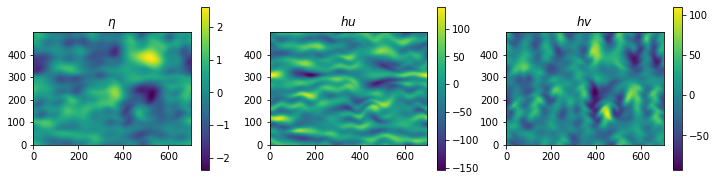

In [34]:
sim = make_sim(model_error_args)
fine_mekl.perturbSim(sim)
imshowSim(sim)
sim.step(10000)
imshowSim(sim)

# Test API for perturbing similar as other sim/model error

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:214: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


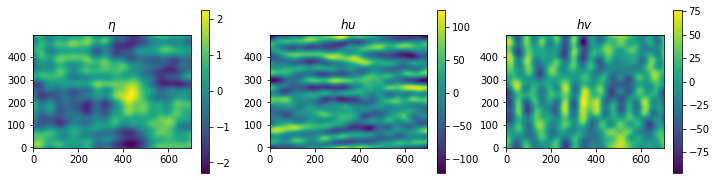

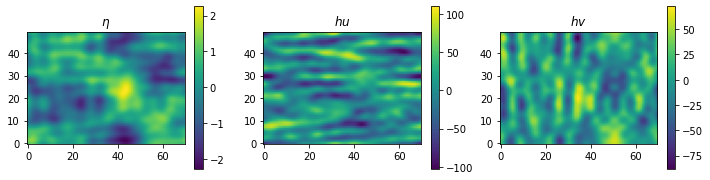

In [35]:
reload(ModelErrorKL)

sim_fine   = make_sim(model_error_args)
sim_coarse = make_sim(model_error_args_coarse)

fine_mekl   = ModelErrorKL.ModelErrorKL(**model_error_args) 
coarse_mekl = ModelErrorKL.ModelErrorKL(**model_error_args_coarse) 

fine_mekl.perturbSim(sim_fine)
coarse_mekl.perturbSimSimilarAs(sim_coarse, modelError=fine_mekl)

imshowSim(sim_fine)
imshowSim(sim_coarse)

